## Formulazione del problema

La natura intermittente e lo scarso controllo sulle condizioni del vento pongono lo stesso problema a tutti i gestori di rete nella loro integrazione per soddisfare la domanda corrente. Oltre a dover prevedere la domanda e bilanciarla con l'offerta, l'operatore di rete deve anche prevedere la disponibilità degli impianti di generazione eolica e solare nell'ora, nel giorno o nella settimana successivi. Oltre a frenare i benefici dell'energia rinnovabile, una programmazione errata degli impianti di generazione eolica può portare a prenotazioni non necessarie, a costi più elevati trasferiti ai consumatori e all'utilizzo di altre risorse energetiche più costose e inquinanti. Lavorare con dati reali è difficile a causa del rumore e dei periodi mancanti.


## Dettaglio del dataset

link dataset: https://www.kaggle.com/datasets/pravdomirdobrev/texas-wind-turbine-dataset-simulated

Le serie orarie annuali fornite sono state simulate utilizzando il software del National Renewable Energy Laboratory (NREL) per una località del Texas, negli Stati Uniti. Presenta una perfetta completezza dei dati e l'assenza di dati rumorosi; sfide che ostacolano le attività di previsione con i set di dati reali e distraggono dall'obiettivo. Il set di dati contiene diverse caratteristiche meteorologiche che possono essere analizzate e utilizzate come predittori.

## Dettagli del task
Prevedere la produzione di energia del giorno successivo = 24 passi avanti.

In particolare noi ci concentreremo solo sull'analisi decrittiva del dataset e sulla sua elaborazione con gli strumenti che abbiamo appreso. Faremo una prova di previsione con una baseline basata sul valore precedente.

### Import del Dataset

In [58]:
import pandas as pd

df = pd.read_csv("TexasTurbine.csv")

### Esplorazione di base

In [2]:
df.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


In [5]:
df.dtypes

Time stamp                        object
System power generated | (kW)    float64
Wind speed | (m/s)               float64
Wind direction | (deg)             int64
Pressure | (atm)                 float64
Air temperature | ('C)           float64
dtype: object

In [7]:
print(f"il dataset presenta {df.size} righe")

il dataset presenta 52560 righe


In [9]:
df.describe()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,964.467934,7.376120,146.616210,0.992368,22.147298
std,878.558112,3.138291,84.678754,0.005332,4.855232
min,0.000000,0.119000,0.000000,0.974514,3.263000
25%,215.951500,5.121000,99.000000,0.988925,19.463000
50%,693.968500,7.340500,135.000000,0.991495,22.763000
75%,1562.287500,9.599000,169.000000,0.995045,26.063000
max,3004.010000,19.743000,360.000000,1.014510,32.963000


In [34]:
start = df["Time stamp"].iloc[0]
end = df["Time stamp"].iloc[-1]
print(f"Il periodo coperto va dal {start} al {end} di un anno ipotetico.")

Il periodo coperto va dal Jan 1, 12:00 am al Dec 31, 11:00 pm di un anno ipotetico.


## Data cleaning

In [37]:
# count missing values
df.isna().sum()

Time stamp                       0
System power generated | (kW)    0
Wind speed | (m/s)               0
Wind direction | (deg)           0
Pressure | (atm)                 0
Air temperature | ('C)           0
dtype: int64

In [59]:
rename_dict = {'Time stamp':'ts',
'System power generated | (kW)': 'potenza',
'Wind speed | (m/s)': 'velocità',
'Wind direction | (deg)':'direzione',
'Pressure | (atm)': 'pressione',
"Air temperature | ('C)": 'temperatura'}

df = df.rename(columns=rename_dict)

In [81]:
# Converte la colonna 'dt' in oggetti datetime
df['ts'] = pd.to_datetime(df['ts'], format='%b %d, %I:%M %p')

# Crea un nuovo DataFrame con l'indice impostato sulla colonna 'dt'
df_ts = df.set_index('ts')

In [62]:
df_ts.head()

,potenza,velocità,direzione,pressione,temperatura
ts,,,,,
1900-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263
1900-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363
1900-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663
1900-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763
1900-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963


### Gestione dell'indice temporale

Quando si lavora con dati di serie temporali, è importante che le informazioni relative al tempo siano in un formato facilmente leggibile dal computer. È qui che gli oggetti datetime si rivelano utili. Convertendo la colonna 'Time stamp' da un oggetto stringa a un oggetto datetime, è possibile eseguire varie operazioni sui dati, come filtrare, aggregare e tracciare in base a intervalli di tempo come giorni, settimane, mesi e così via.

Ad esempio, possiamo facilmente raggruppare i dati per mese e calcolare la potenza media generata per mese, il che può aiutarci a identificare tendenze e modelli nei dati. Inoltre, gli oggetti datetime forniscono vari attributi e metodi che consentono di estrarre informazioni specifiche dalla data e dall'ora, come il mese, il giorno, l'ora, il minuto, ecc. Questo può aiutarci a eseguire analisi più granulari e a ottenere approfondimenti sui dati.

In generale, la conversione della colonna 'Time stamp' in un oggetto datetime facilita il lavoro con i dati delle serie temporali e consente di eseguire analisi e visualizzazioni più sofisticate.

La libreria datetime è molto utile per lavorare con dati di serie temporali, poiché offre metodi per effettuare la conversione tra diversi formati di data e tempo, la creazione di intervalli di tempo e l'accesso a parti specifiche di una data o ora. Inoltre, è possibile eseguire operazioni matematiche come la somma e la sottrazione di date e orari, rendendo la libreria datetime uno strumento molto versatile per l'analisi dei dati.

Per trasformare correttamente la colonna 'Time stamp' in un oggetto datetime, possiamo utilizzare il metodo pd.to_datetime di Pandas, specificando il formato della stringa di input utilizzando i codici di formato. In questo caso, il formato corretto della stringa è '%b %d, %I:%M %p', dove:

'%b' rappresenta il mese abbreviato in tre lettere (es. Jan per Gennaio)
'%d' rappresenta il giorno del mese (01-31)
'%I' rappresenta l'ora in formato 12 ore (01-12)
'%M' rappresenta i minuti (00-59)
'%p' rappresenta l'indicatore AM o PM

In [63]:
df_ts

,potenza,velocità,direzione,pressione,temperatura
ts,,,,,
1900-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263
1900-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363
1900-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663
1900-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763
1900-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963
...,...,...,...,...,...
1900-12-31 19:00:00,1234.70,8.848,129,0.998604,19.663
1900-12-31 20:00:00,1105.37,8.502,118,1.000090,19.063
1900-12-31 21:00:00,1405.71,9.224,117,0.998408,18.463


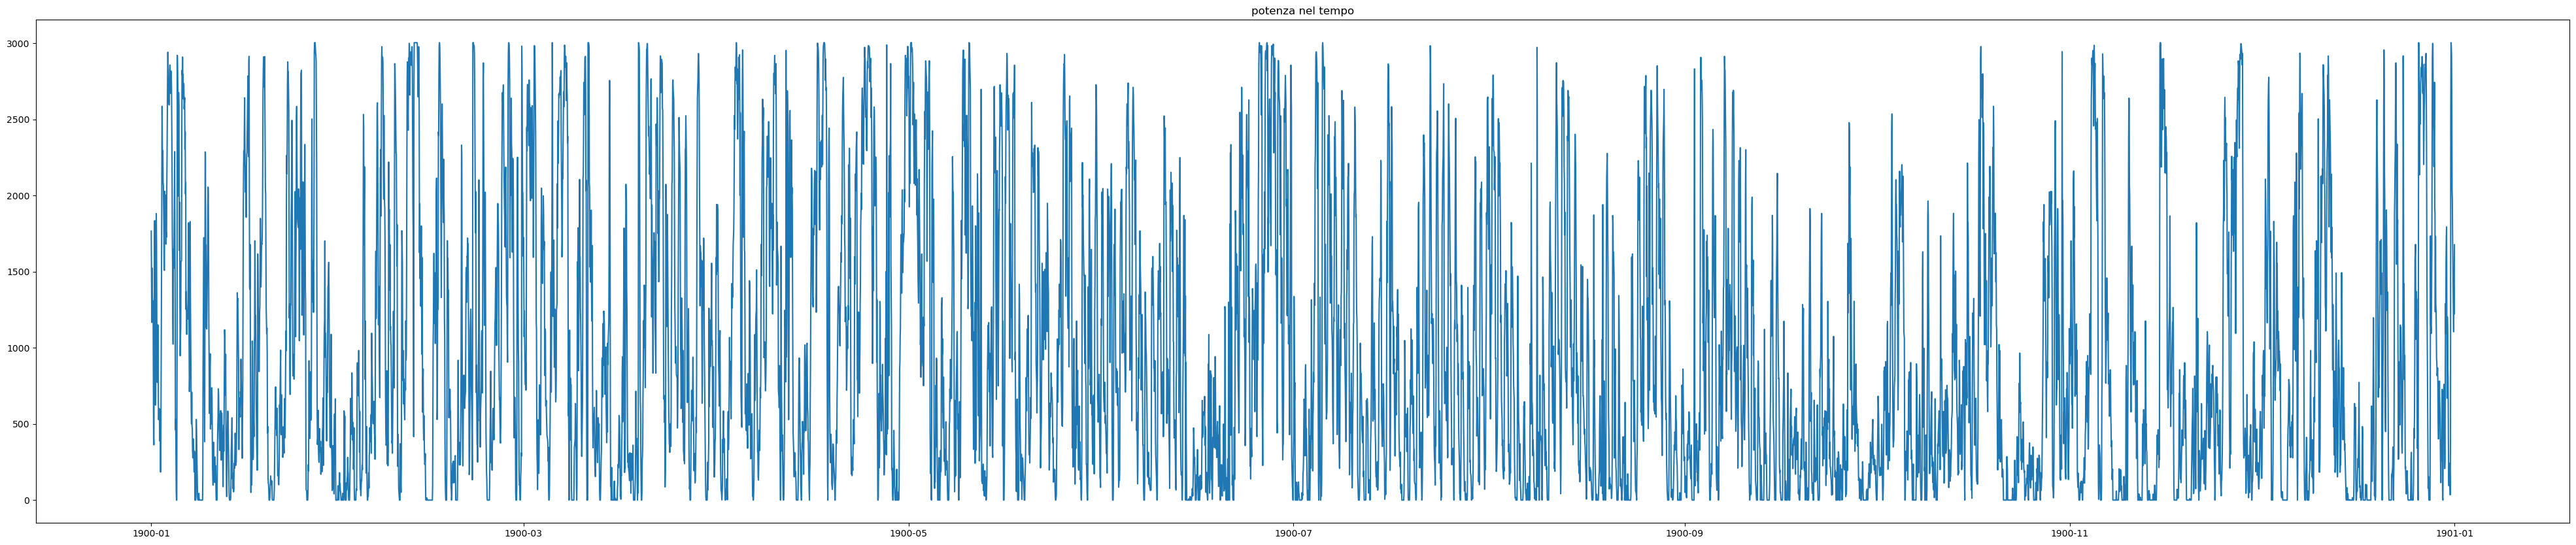

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 10))
plt.plot(df_ts['potenza'])
plt.title('potenza nel tempo')
plt.show()

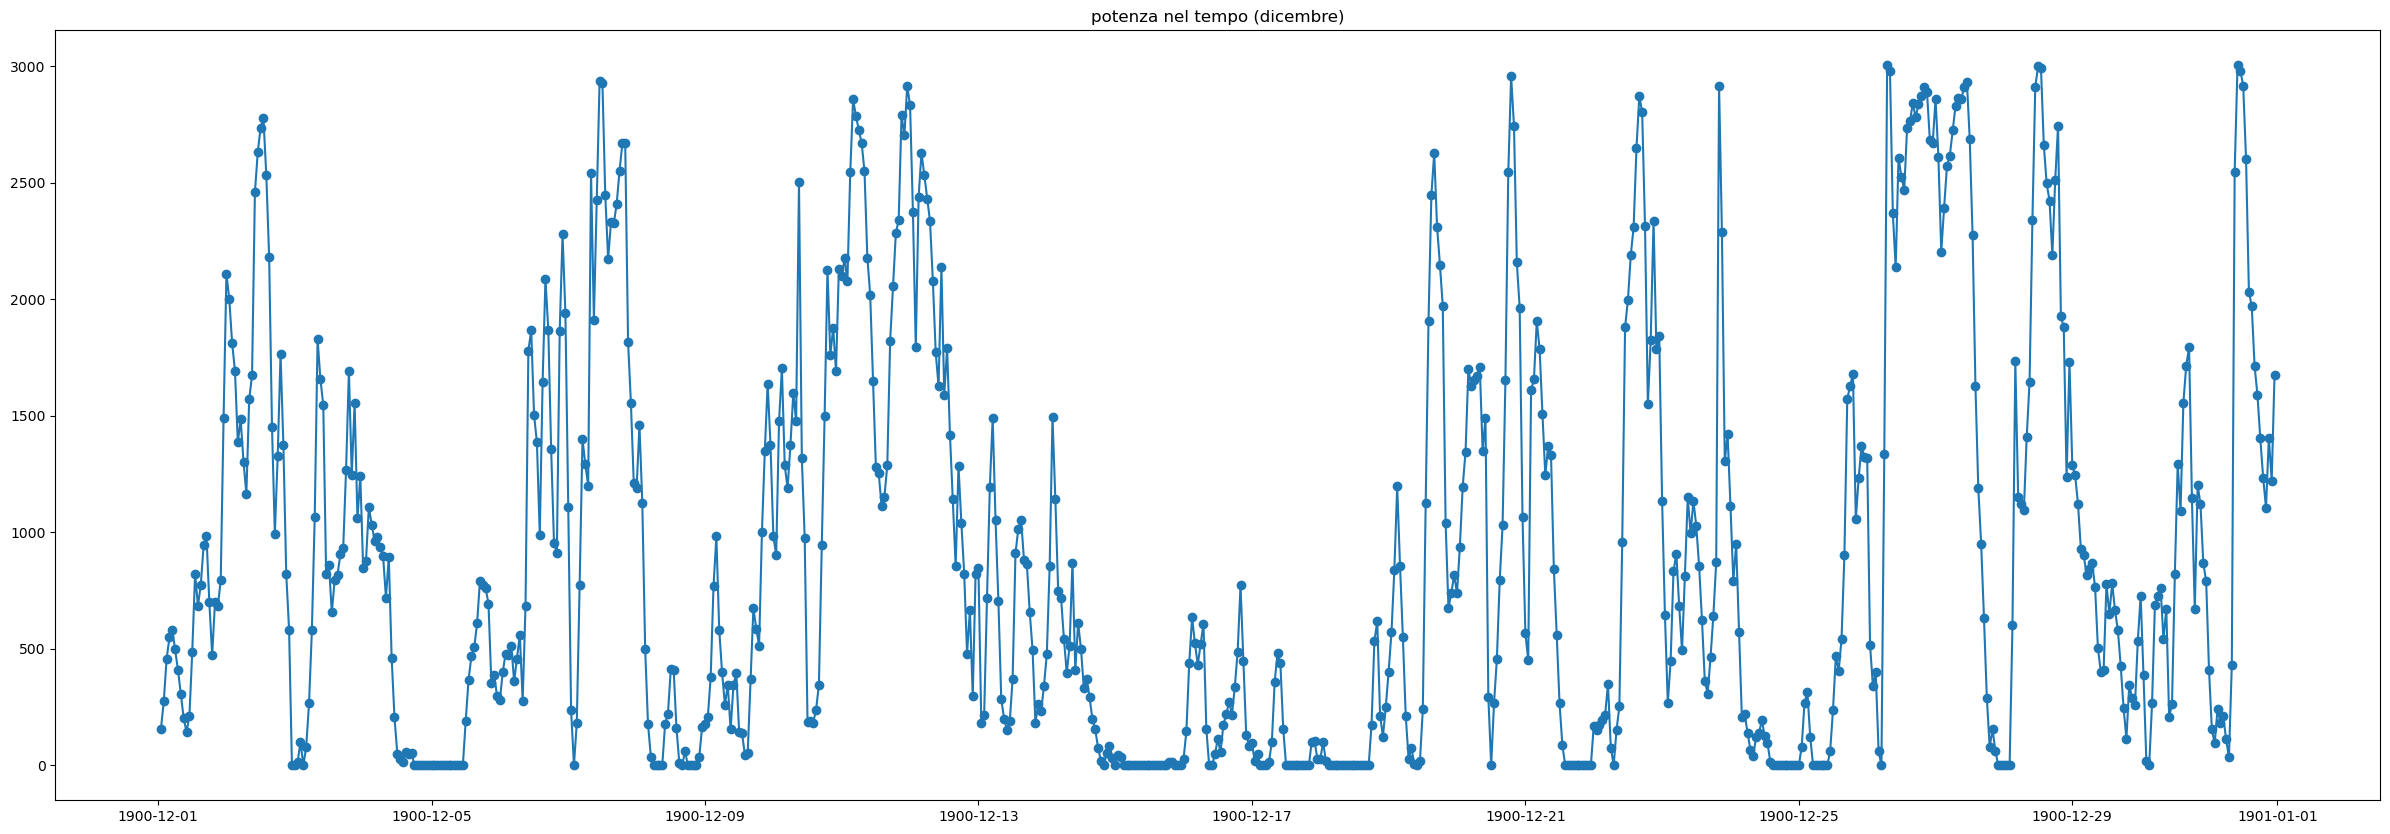

In [115]:
plt.figure(figsize=(30, 10))
cond = df_ts.index >'1900-12-01 00:00:00'
plt.plot(df_ts['potenza'].loc[cond], '-o')
plt.title('potenza nel tempo (dicembre)')
plt.show()

## Analisi aggregata
possiamo effettuare un'analisi aggregata sulla produzione totale della giornata e su altre variabili prese come media della giornata. Per fare ciò, possiamo usare il metodo groupby() di Pandas per raggruppare i dati per giorno e calcolare la somma della potenza generata e la media delle altre variabili per ciascun giorno.

In [104]:
# Estraiamo la data come una nuova colonna
df_ts['giorno'] = df_ts.index.date

# Calcoliamo la somma della potenza generata e la media delle altre variabili per giorno
daily_data = df_ts.groupby('giorno').agg({'potenza': 'sum',
                                      'velocità': 'mean',
                                      'direzione': 'mean',
                                      'pressione': 'mean',
                                      'temperatura': 'mean'}).reset_index()
# Visualizziamo le prime righe del nuovo dataframe
print(daily_data.head())


       giorno     potenza   velocità   direzione  pressione  temperatura
0  1900-01-01  27924.4600   8.523375  141.125000   0.998999    19.894250
1  1900-01-02  28637.7610   8.400458  156.416667   0.996132    20.413000
2  1900-01-03  54029.0500  11.291250  154.958333   0.991826    20.558833
3  1900-01-04  41996.9344   9.905917  157.416667   0.988897    21.081750
4  1900-01-05  44606.9810   9.906000   21.750000   0.998112    13.271333


0     1900-01-01
1     1900-01-02
2     1900-01-03
3     1900-01-04
4     1900-01-05
         ...    
360   1900-12-27
361   1900-12-28
362   1900-12-29
363   1900-12-30
364   1900-12-31
Name: giorno, Length: 365, dtype: datetime64[ns]

In [110]:
# Converte la colonna 'dt' in oggetti datetime
daily_data['giorno'] = pd.to_datetime(daily_data['giorno'])

# Crea un nuovo DataFrame con l'indice impostato sulla colonna 'dt'
daily_data = daily_data.set_index('giorno')

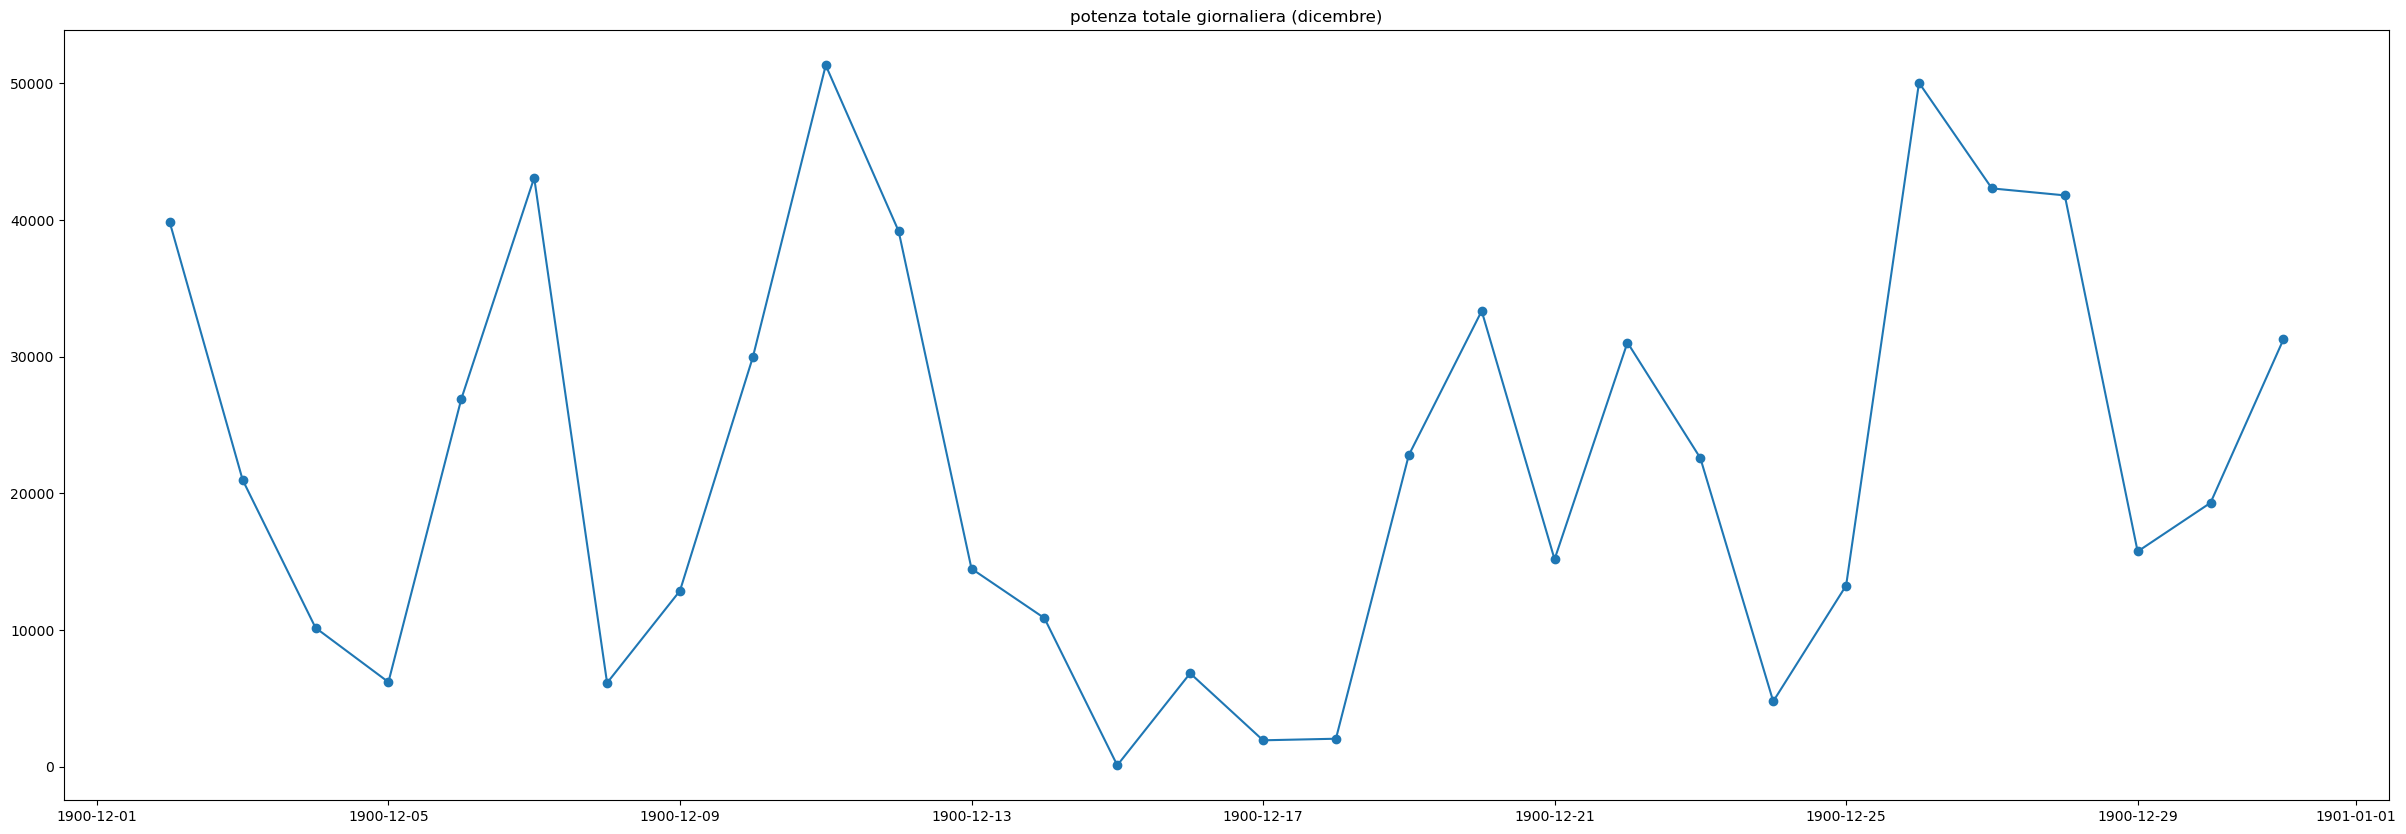

In [118]:
plt.figure(figsize=(30, 10))
cond = daily_data.index >'1900-12-01 00:00:00'
plt.plot(daily_data['potenza'].loc[cond],'-o')
plt.title('potenza totale giornaliera (dicembre)')
plt.show()

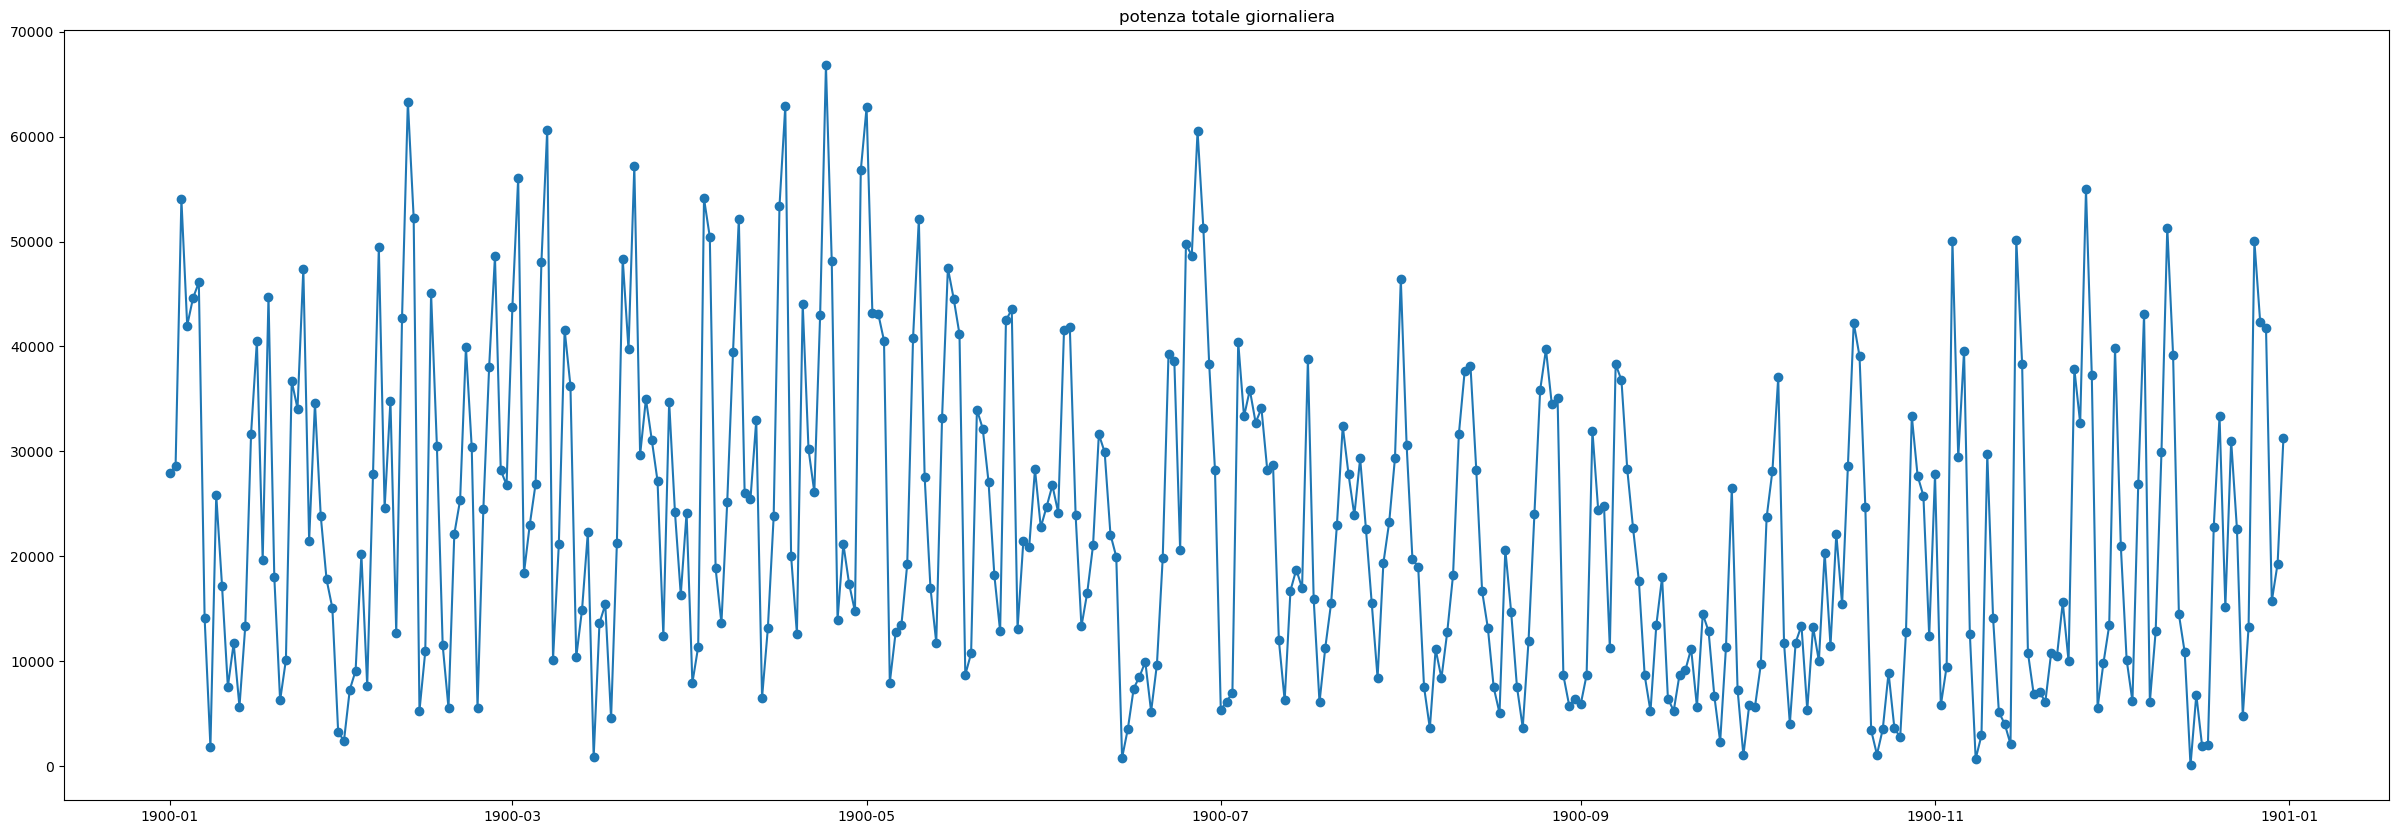

In [119]:
plt.figure(figsize=(30, 10))
plt.plot(daily_data['potenza'],'-o')
plt.title('potenza totale giornaliera')
plt.show()

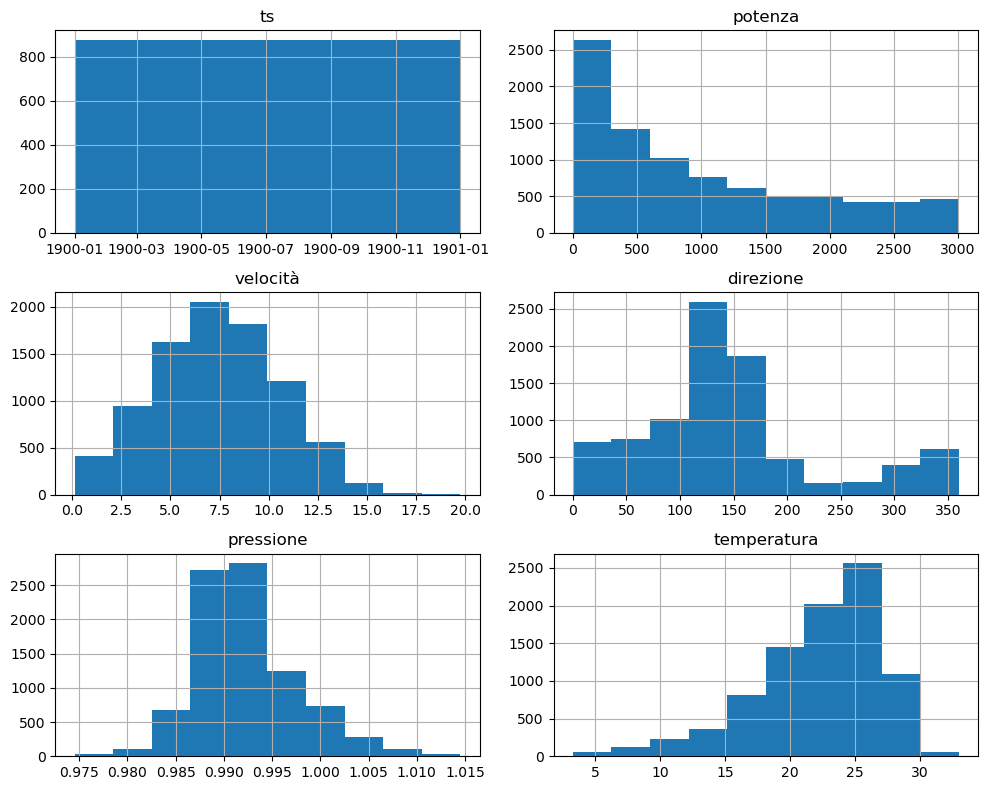

In [120]:
import matplotlib.pyplot as plt


df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

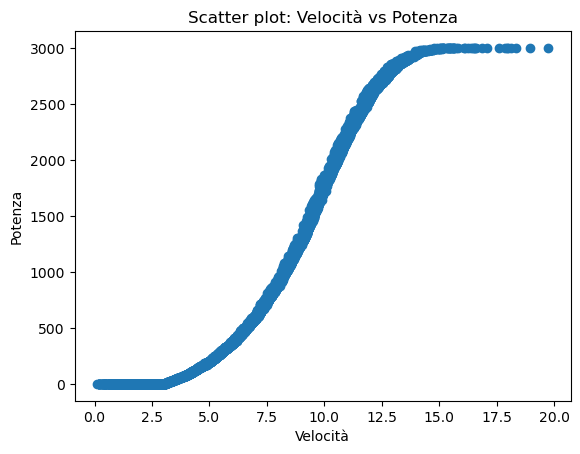

In [121]:
plt.scatter(df_ts['velocità'], df_ts['potenza'])
plt.xlabel('Velocità')
plt.ylabel('Potenza')
plt.title('Scatter plot: Velocità vs Potenza')
plt.show()
